## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os                                                                       
import numpy as np                                                              
import tensorflow as tf                                                         
import data.data_selector as ds                                                   
import analysis.analysis_picker as ap
import utils.plot_functions as pf                                               

## Model parameters

In [3]:
analysis_params = {
  "model_type": "lca_pca",
  "model_name": "lca_pca_512_vh_ft_white",
  "version": "0.0",
  "save_info": "300k_imgs"}

# Computed params
analysis_params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"
  +analysis_params["model_name"])

## Load analyzer

In [ ]:
analyzer = ap.get_analyzer(analysis_params)
analyzer.model.setup(analyzer.model_params, analyzer.model_schedule)
analyzer.load_analysis(save_info=analysis_params["save_info"])

#ot_bf_indices = analyzer.ot_grating_responses["neuron_indices"]
#ot_contrasts = analyzer.ot_grating_responses["contrasts"]
#ot_phases = analyzer.ot_grating_responses["phases"]
#ot_orientations = analyzer.ot_grating_responses["orientations"]
#ot_best_phases = analyzer.ot_grating_responses["best_phases"]
#ot_mean_activations = analyzer.ot_grating_responses["mean_responses"]
#
#co_bf_indices = analyzer.co_grating_responses["neuron_indices"]
#co_contrasts = analyzer.co_grating_responses["contrasts"]
#co_phases = analyzer.co_grating_responses["phases"]
#co_base_orientations = analyzer.co_grating_responses["base_orientations"]
#co_mask_orientations = analyzer.co_grating_responses["mask_orientations"]
#co_base_mean_responses = analyzer.co_grating_responses["base_mean_responses"]
#co_test_mean_responses = analyzer.co_grating_responses["test_mean_responses"]

## Construct analysis plots

### Run statistics

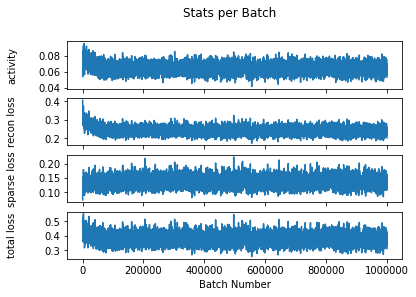

In [5]:
fig = pf.plot_stats(analyzer.run_stats,
  keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"],
  labels=["activity", "recon loss", "sparse loss", "total loss"])
fig.savefig(analyzer.analysis_out_dir+"fig_run_stats.png")

### Neural inputs during inference

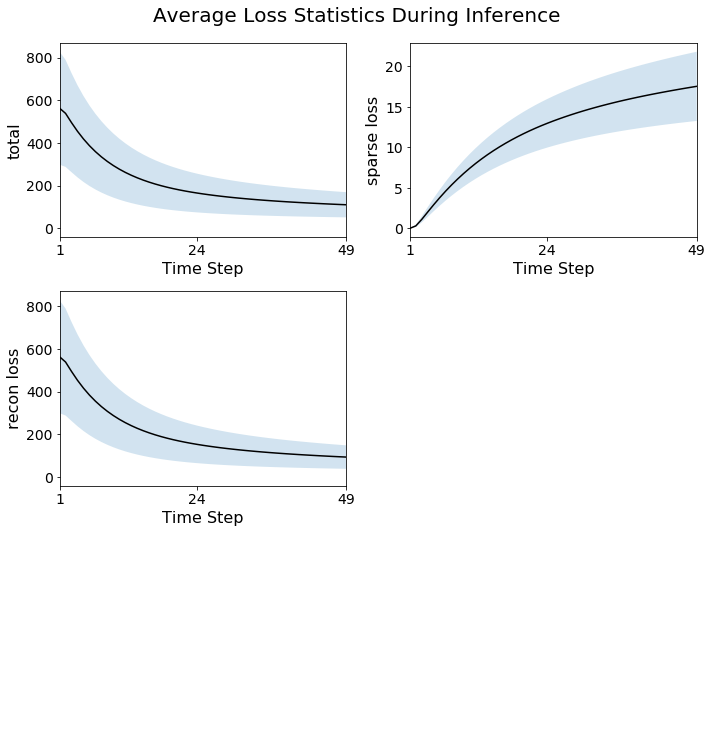

In [9]:
fig = pf.plot_inference_stats(analyzer.inference_stats, title="Average Loss Statistics During Inference")
fig.savefig(analyzer.analysis_out_dir+"fig_inference_stats.pdf")

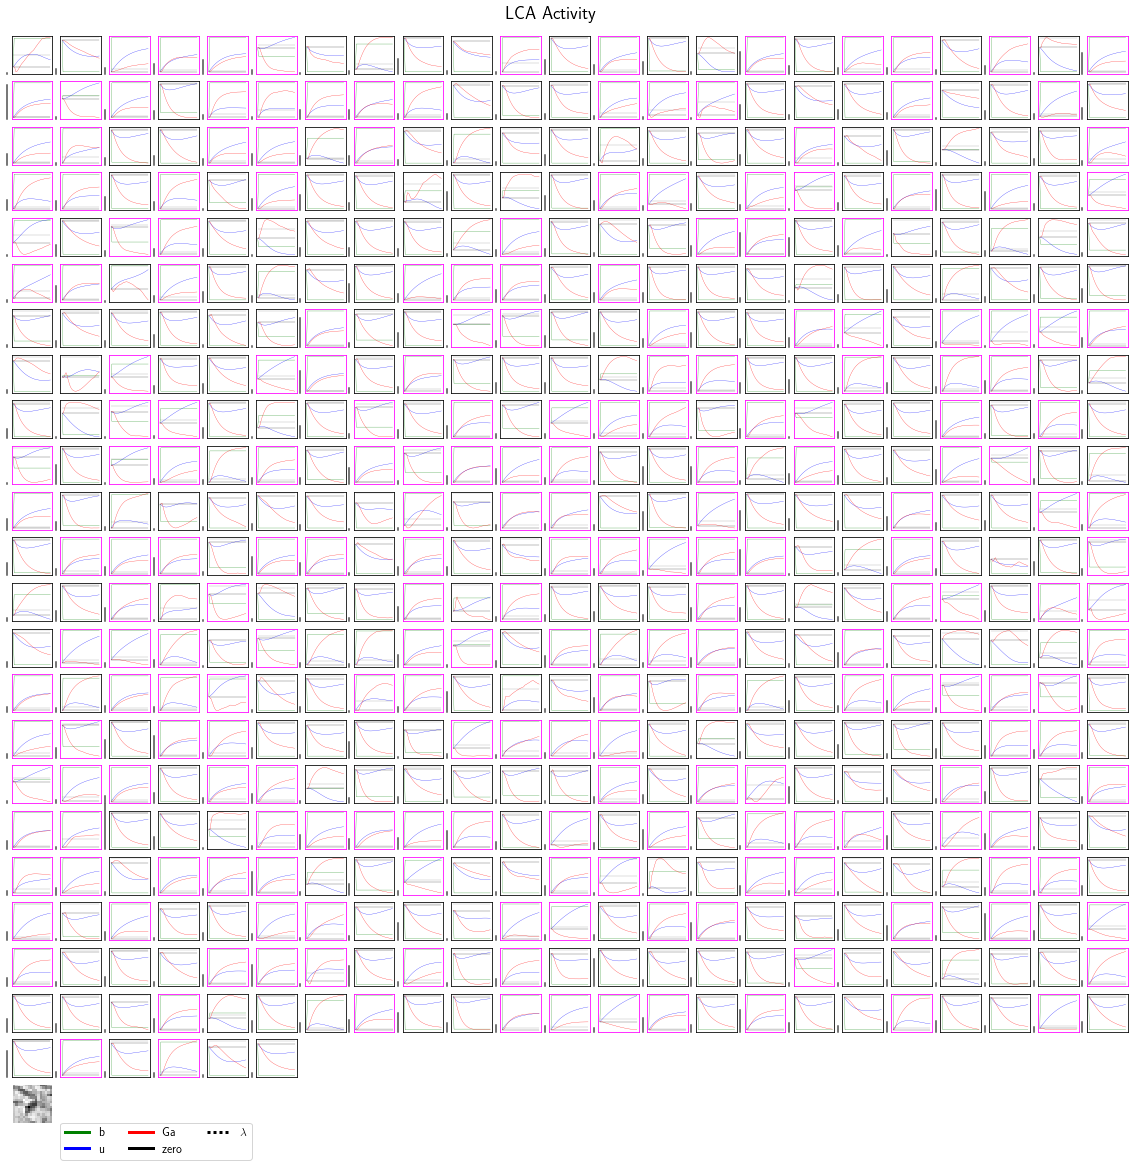

In [10]:
fig = pf.plot_inference_traces(analyzer.inference_stats, analyzer.model_schedule[0]["sparse_mult"], 0)
fig.savefig(analyzer.analysis_out_dir+"fig_inference_traces.pdf")

### Activity triggered averages

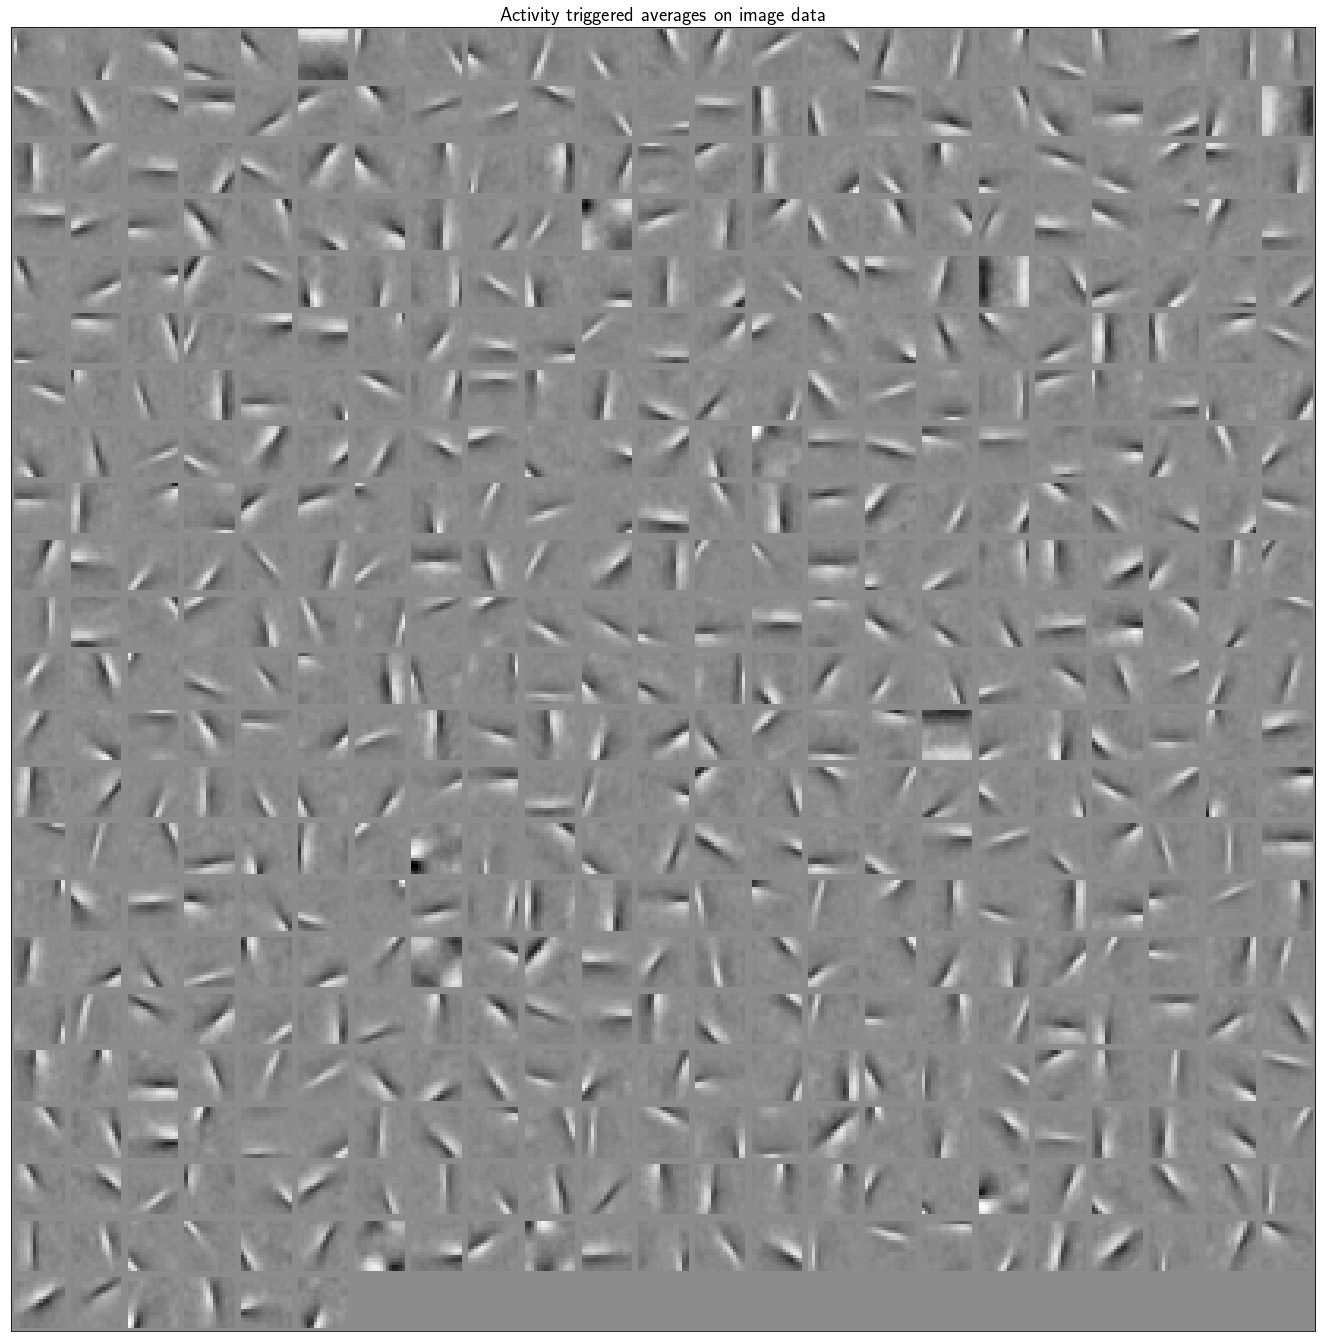

In [15]:
num_pixels, num_neurons = analyzer.atas.shape
fig = pf.plot_data_tiled(analyzer.atas.T.reshape(num_neurons,
  int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels)), 1), normalize=False,
  title="Activity triggered averages on image data")
fig.savefig(analyzer.analysis_out_dir+"fig_l1_atas.png")

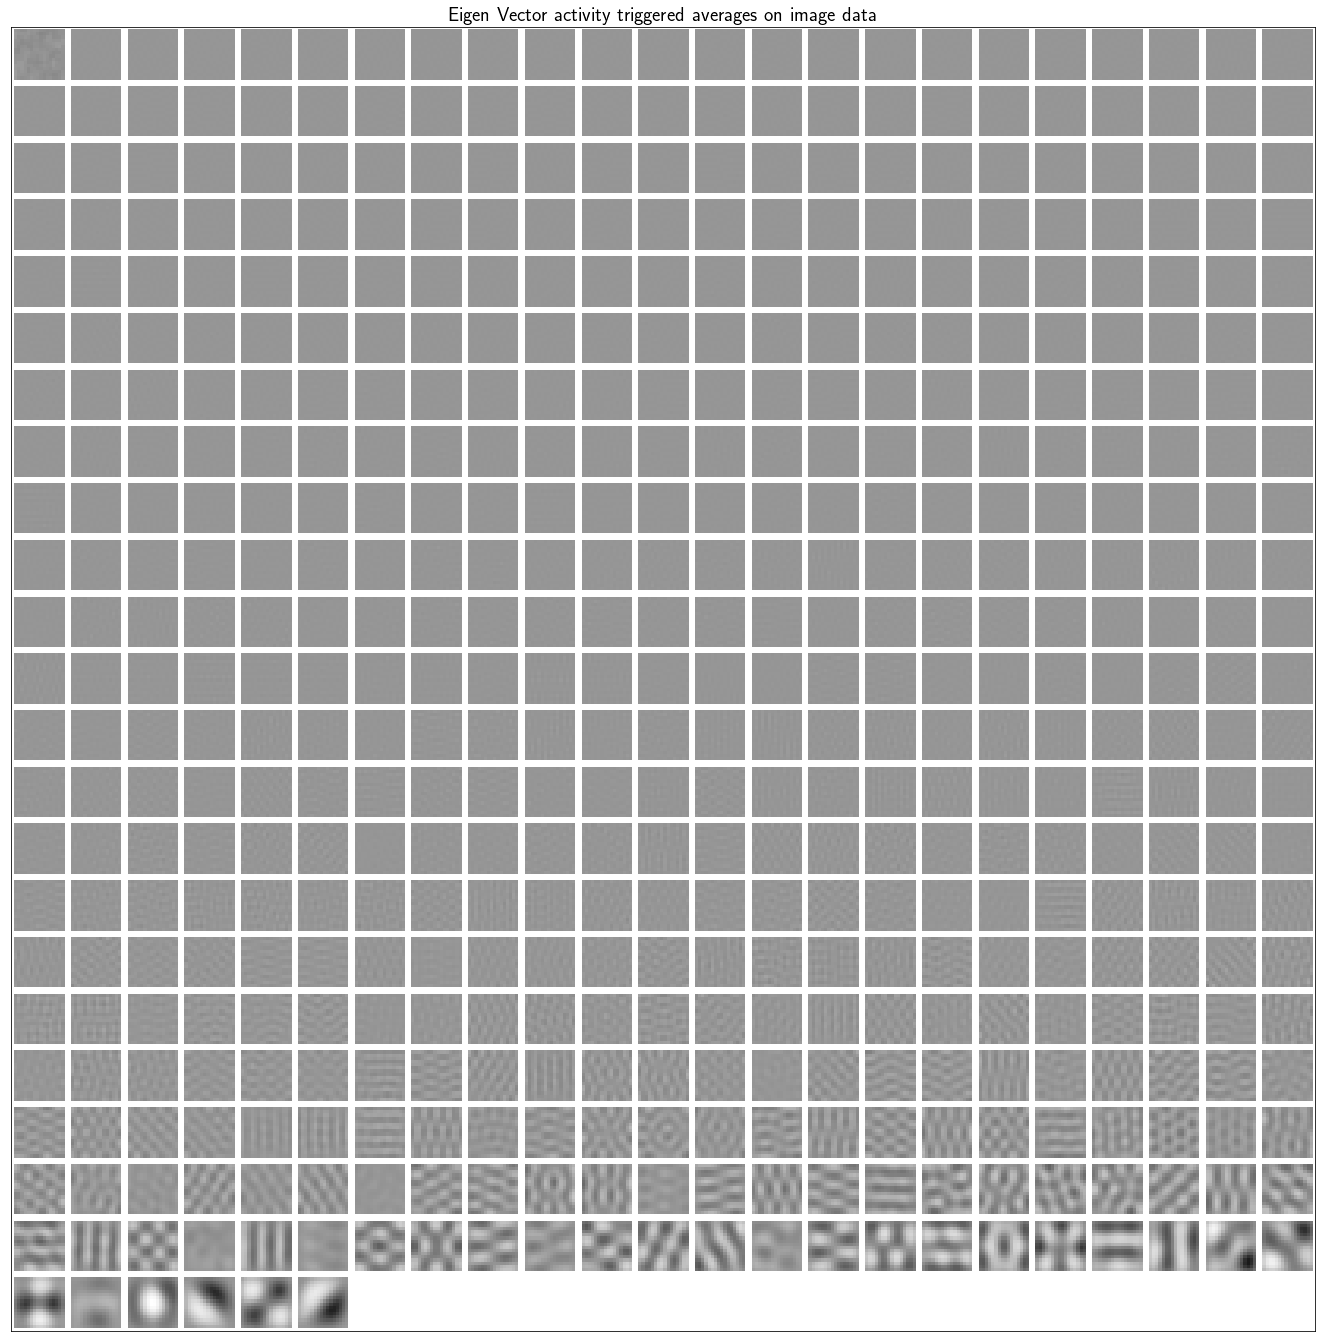

In [16]:
num_pixels, num_neurons = analyzer.evec_atas.shape
fig = pf.plot_data_tiled(analyzer.evec_atas.T.reshape(num_neurons,
  int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels)), 1), normalize=True,
  title="Eigen Vector activity triggered averages on image data")
fig.savefig(analyzer.analysis_out_dir+"fig_eigen_atas.png")

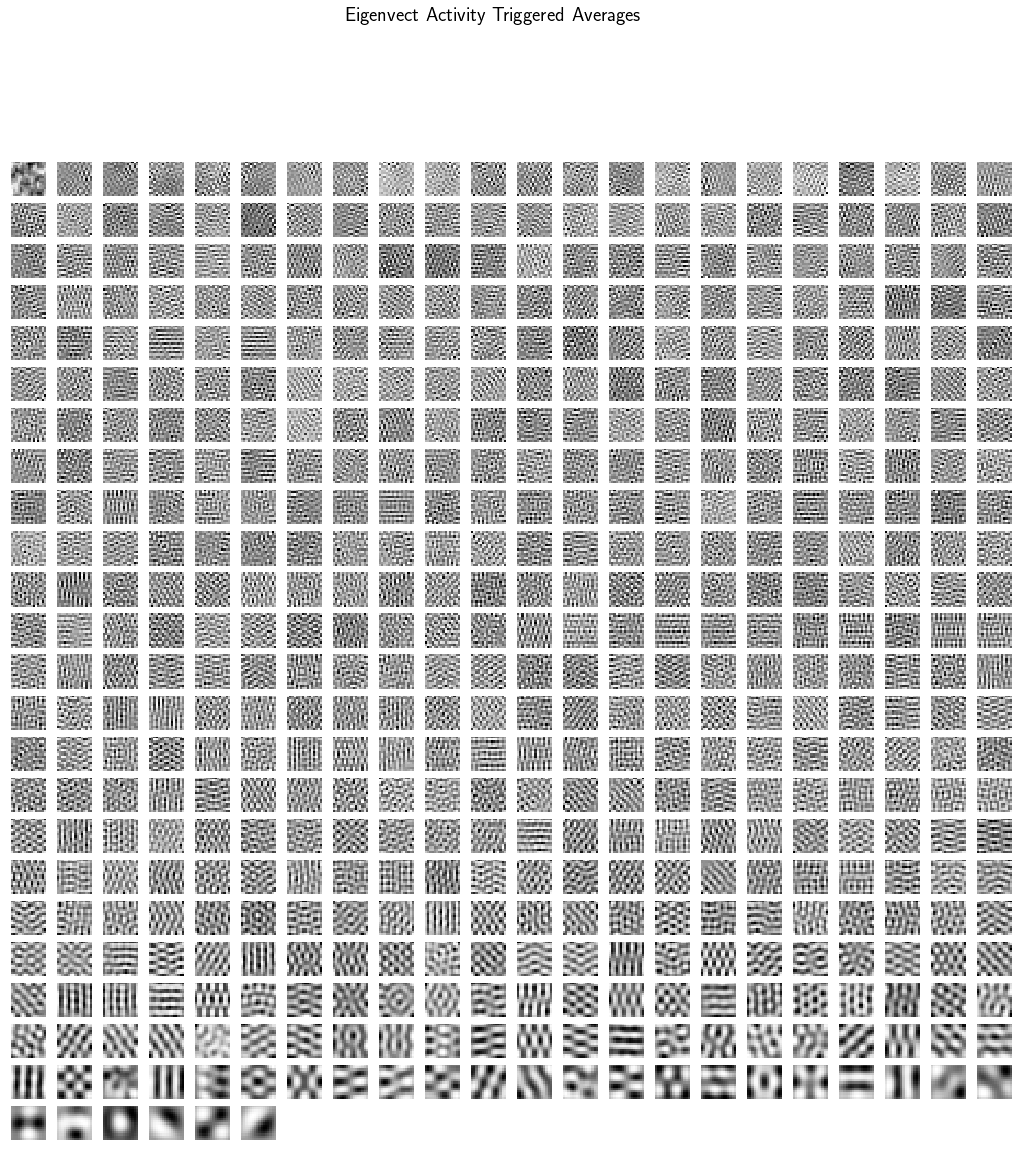

In [17]:
num_pixels, num_neurons = analyzer.evec_atas.shape
fig = pf.plot_weights(analyzer.evec_atas.T.reshape(num_neurons,
  int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels))), title="Eigenvect Activity Triggered Averages")

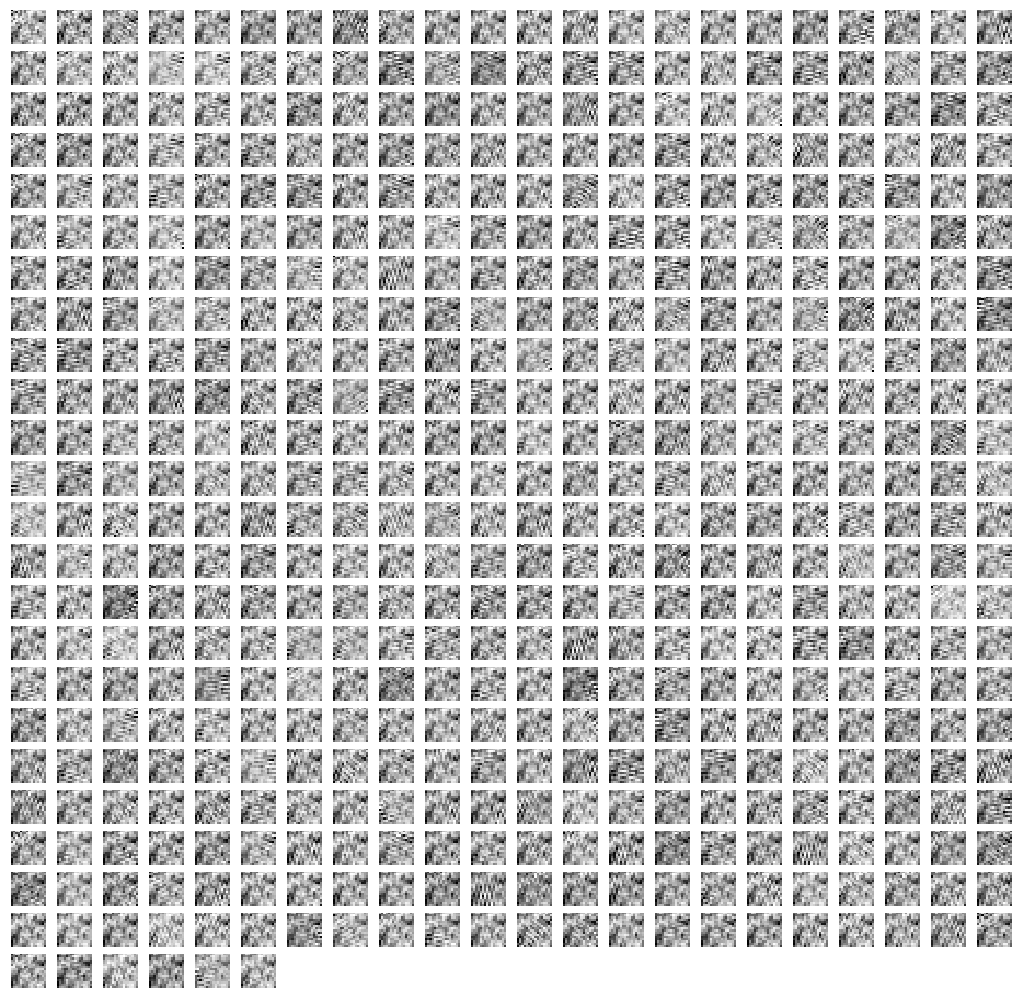

In [18]:
num_pixels, num_neurons = analyzer.pool_atas.shape
fig = pf.plot_weights(analyzer.pool_atas.T.reshape(num_neurons, int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels))))

### Activity covariance matrix summaries

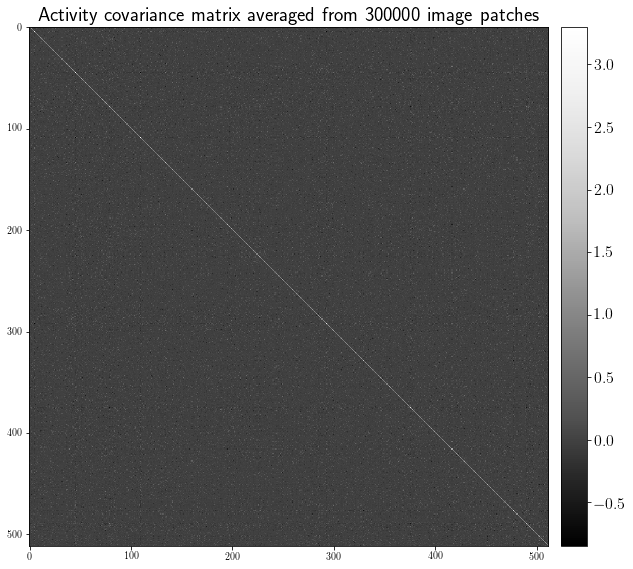

In [19]:
fig_title = "Activity covariance matrix averaged from "+str(analysis_params["cov_num_images"])+" image patches"
fig = pf.plot_matrix(analyzer.cov["act_cov"], fig_title)
fig.savefig(analyzer.analysis_out_dir+"fig_covariance_matrix.png")

/home/dpaiton/tensorflow/lib/python3.4/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


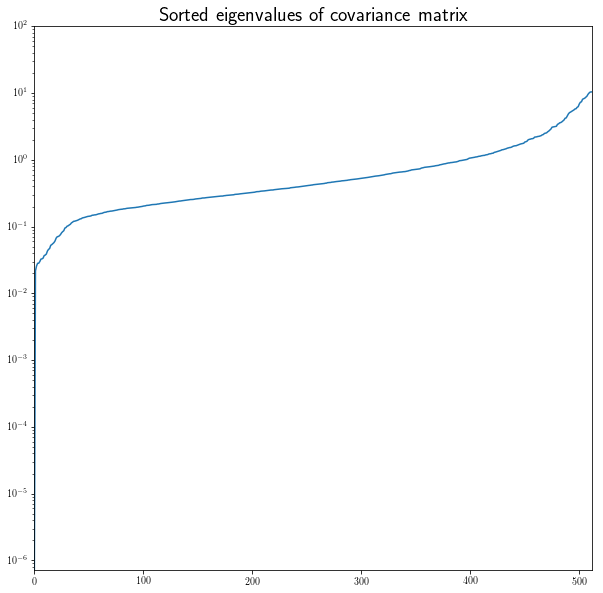

In [20]:
fig = pf.plot_eigenvalues(analyzer.cov["a_eigvals"], ylim=[0,100])
fig.savefig(analyzer.analysis_out_dir+"fig_eigenvalues.png")

/home/dpaiton/tensorflow/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


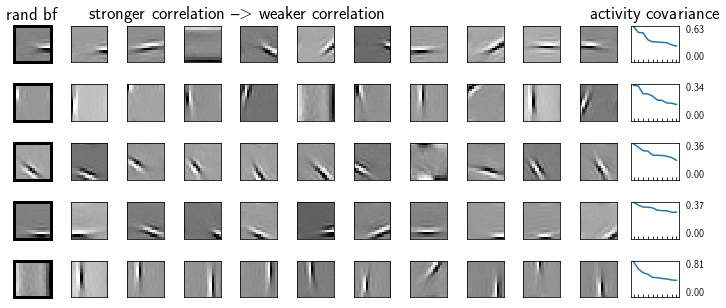

In [21]:
num_random_bases = 5
num_top_cov_bases = 10
bf_indices = np.random.choice(np.arange(analyzer.cov["act_cov"].shape[0]), num_random_bases)
fig = pf.plot_top_bases(analyzer.cov["act_cov"], analyzer.evals["weights/phi:0"],
  bf_indices, num_top_cov_bases)
fig.savefig(analyzer.analysis_out_dir+"fig_top_cov_bases.png")

### Basis function analysis

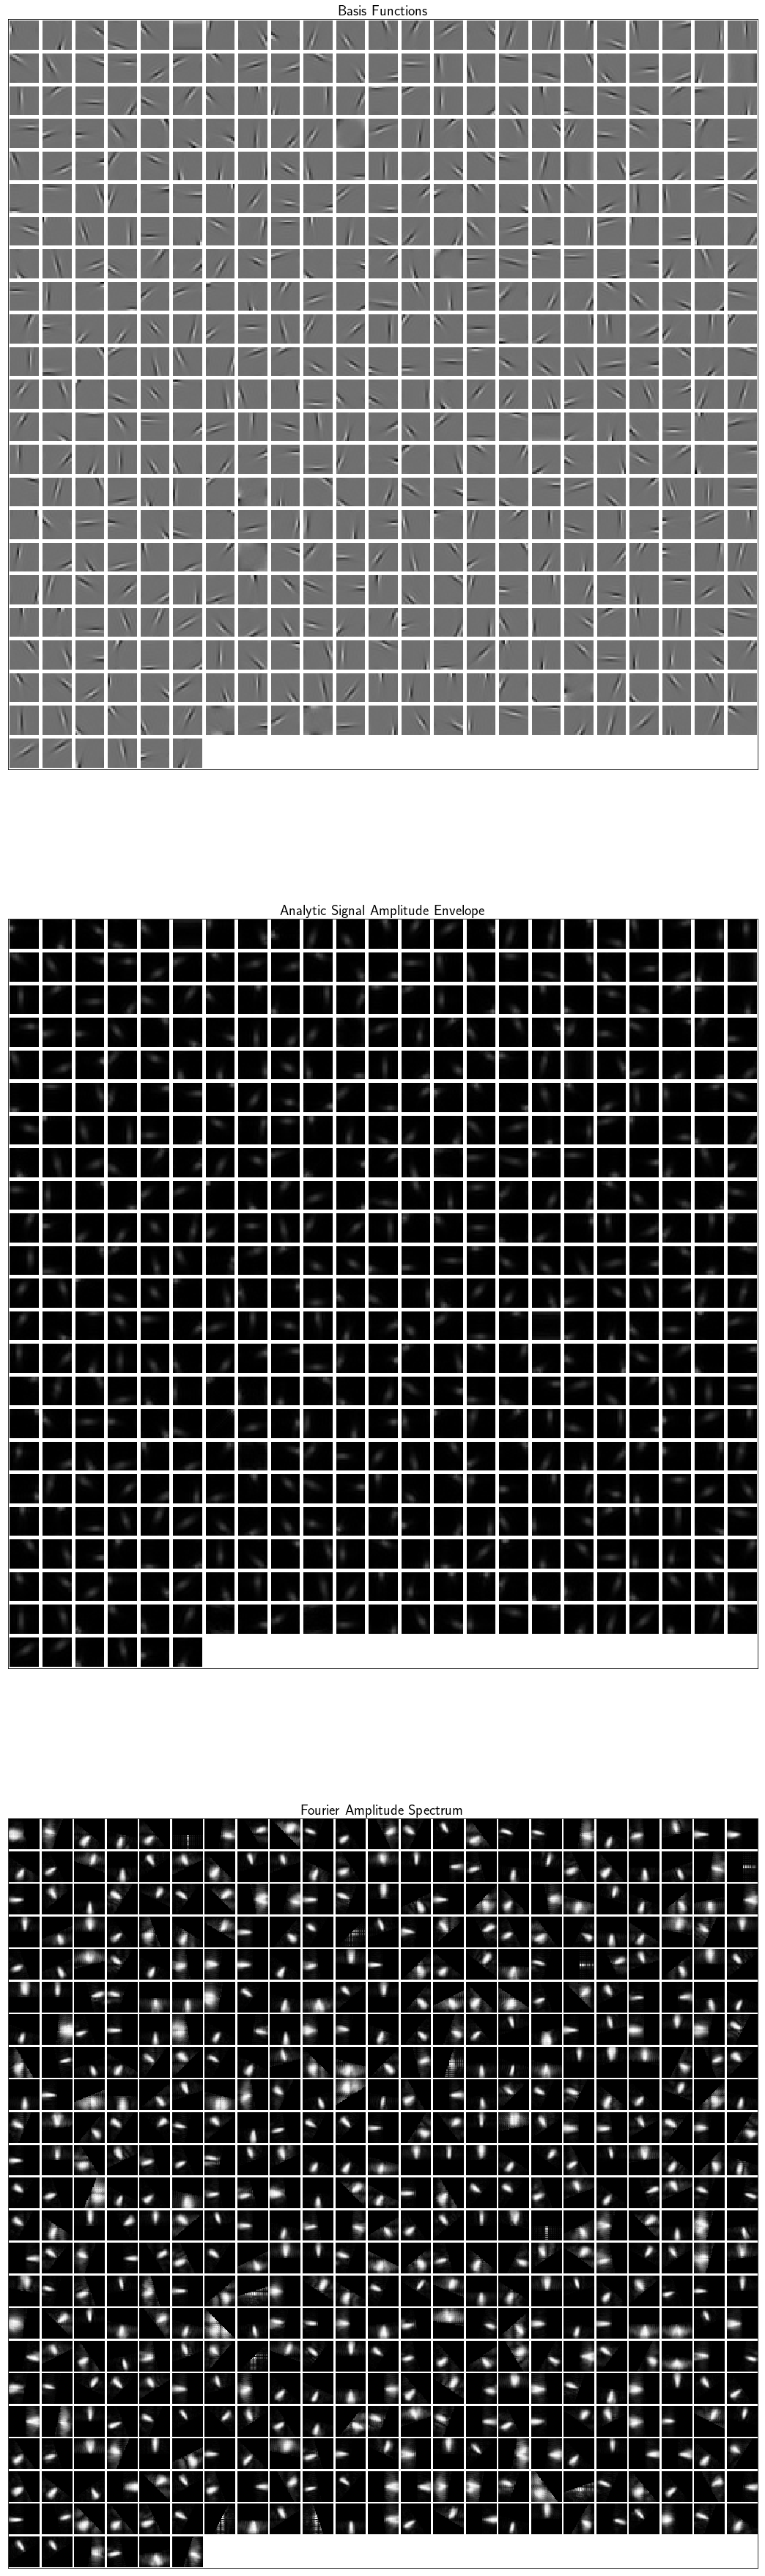

In [22]:
fig = pf.plot_hilbert_analysis(analyzer.evals["weights/phi:0"], analysis_params["ft_padding"])
fig.savefig(analyzer.analysis_out_dir+"fig_hilbert_analysis.png")

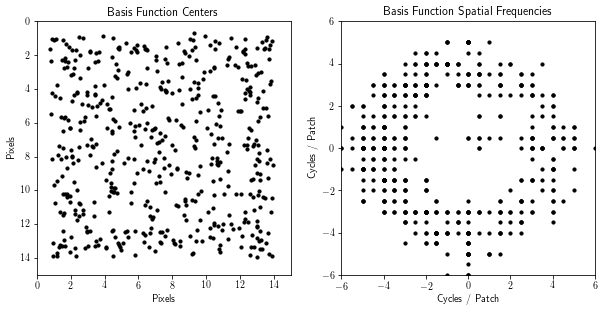

In [23]:
fig = pf.plot_loc_freq_summary(analyzer.bf_stats)
fig.savefig(analyzer.analysis_out_dir+"fig_location_frequency_centers.png")

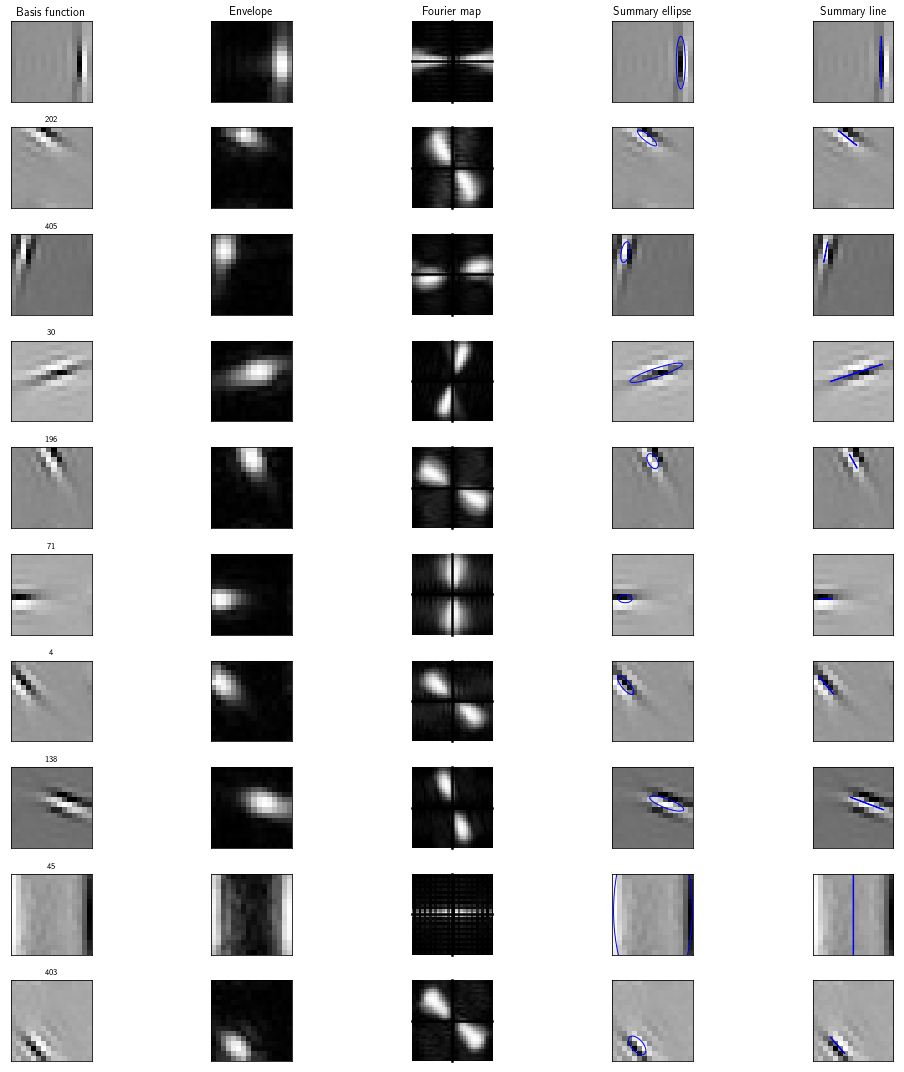

In [24]:
fig = pf.plot_bf_stats(analyzer.bf_stats, num_bf=10)
fig.savefig(analyzer.analysis_out_dir+"fig_basis_function_summary_stats.png")

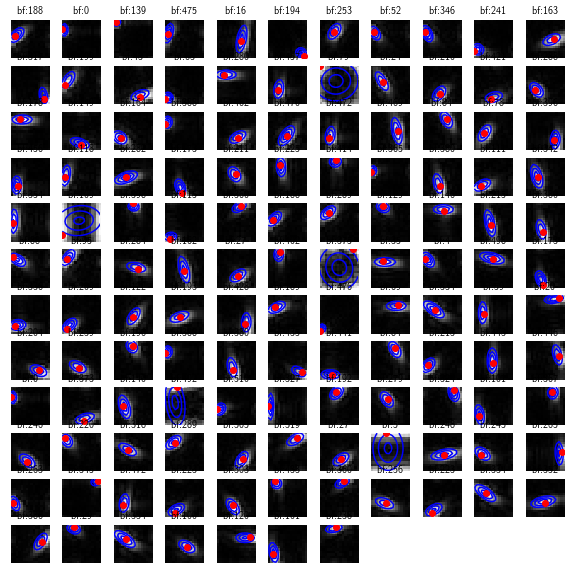

In [25]:
fig = pf.plot_gaussian_contours(analyzer.bf_stats, num_plots=128)
fig.savefig(analyzer.analysis_out_dir+"fig_gauss_contours.png")

### Pooling and eigen summary plots

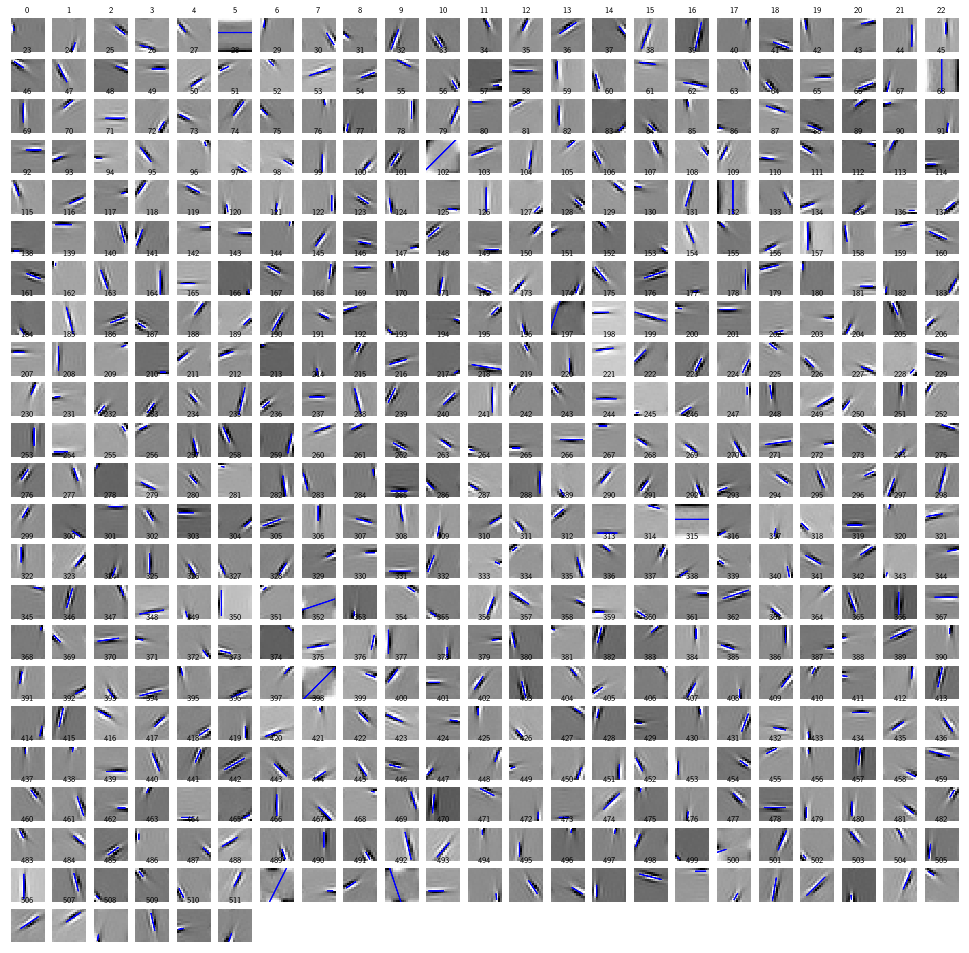

In [26]:
fig = pf.plot_ellipse_summaries(analyzer.bf_stats, num_bf=1000, lines=True)
fig.savefig(analyzer.analysis_out_dir+"fig_ellipse_fitting_summary.png")

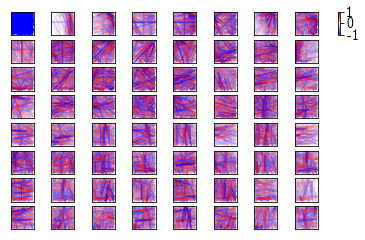

In [27]:
num_pooling_filters = 64 # How many 2nd layer filters to display
num_connected_weights = analyzer.model.num_neurons # How many of strongest connected weight summaries to show
fig = pf.plot_pooling_summaries(analyzer.bf_stats, analyzer.cov["a_eigvecs"],
  num_pooling_filters, num_connected_weights, lines=True)
fig.savefig(analyzer.analysis_out_dir+"fig_eigen_pooling_lines.png")

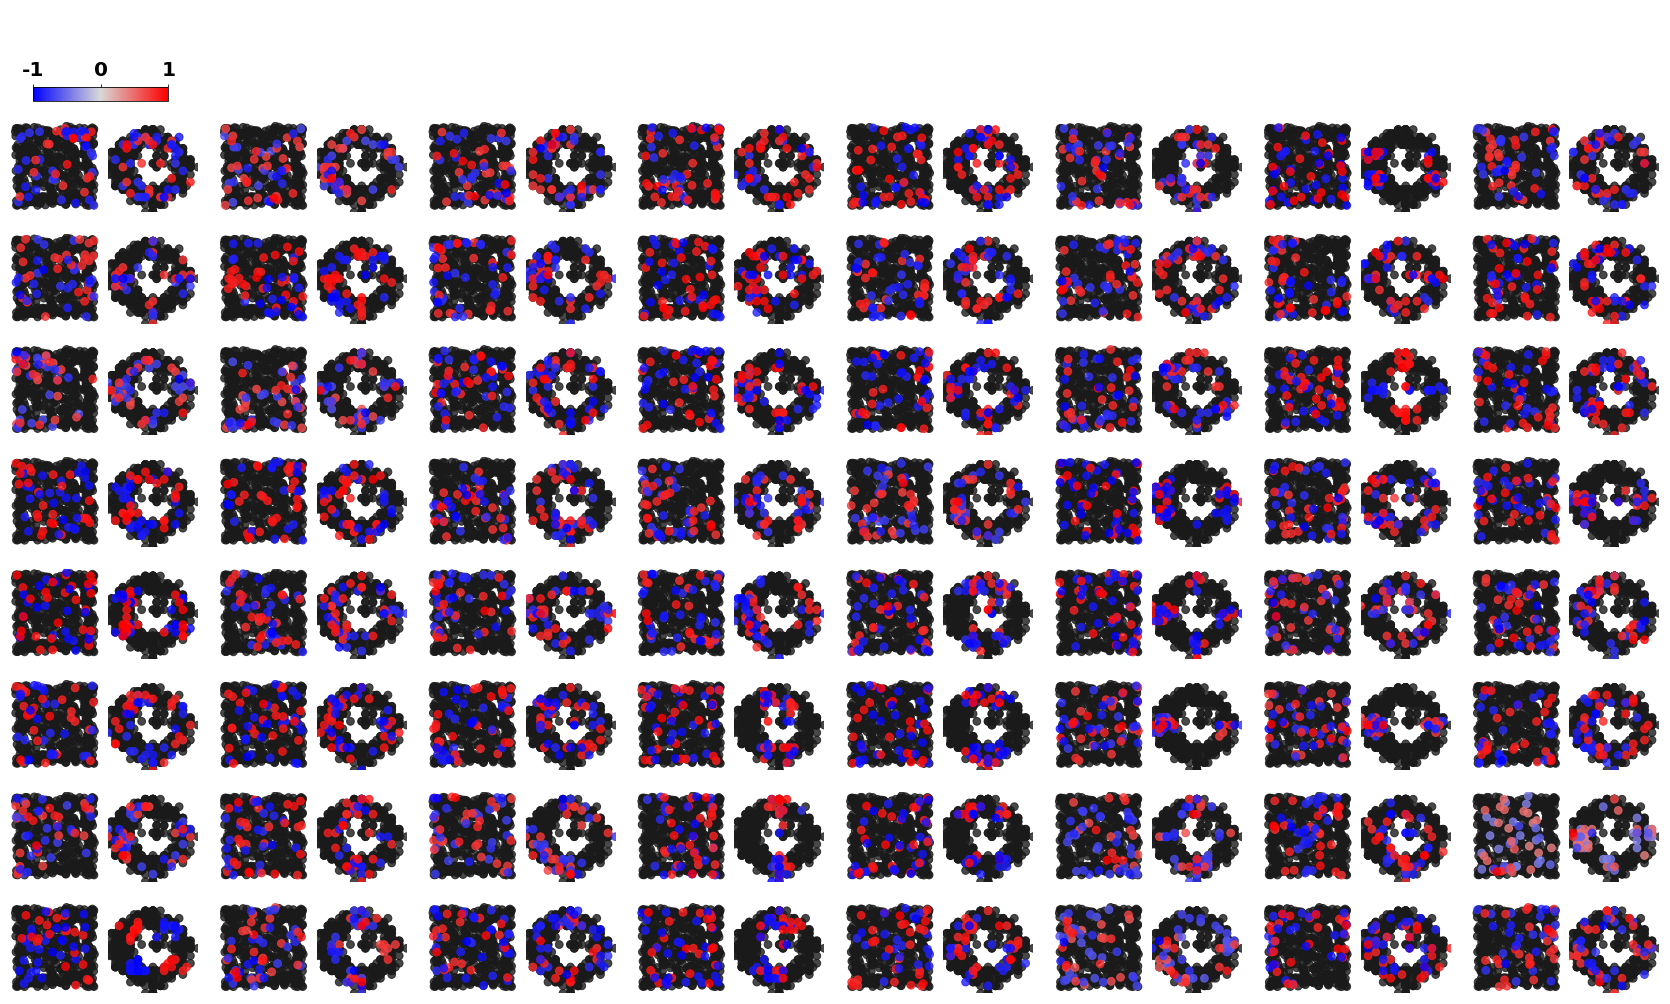

In [6]:
num_pooling_filters = 64
num_connected_weights = 50
filter_indices = None
fig_size = (10, 10)
spot_size = 60
fig = pf.plot_pooling_centers(analyzer.bf_stats, analyzer.cov["a_eigvecs"], num_pooling_filters,
  num_connected_weights, filter_indices, spot_size, figsize=fig_size)
fig.savefig(analyzer.analysis_out_dir+"fig_eigen_pooling_centers.png", bbox_inches="tight")

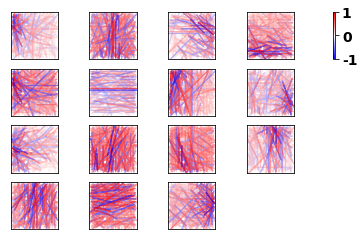

In [8]:
num_pooling_filters = 15
num_connected_weights = analyzer.model.num_neurons
fig = pf.plot_pooling_summaries(analyzer.bf_stats, analyzer.cov["pooling_filters"], num_pooling_filters,
  num_connected_weights, lines=True)
fig.savefig(analyzer.analysis_out_dir+"fig_reduc_pooling_lines.png")

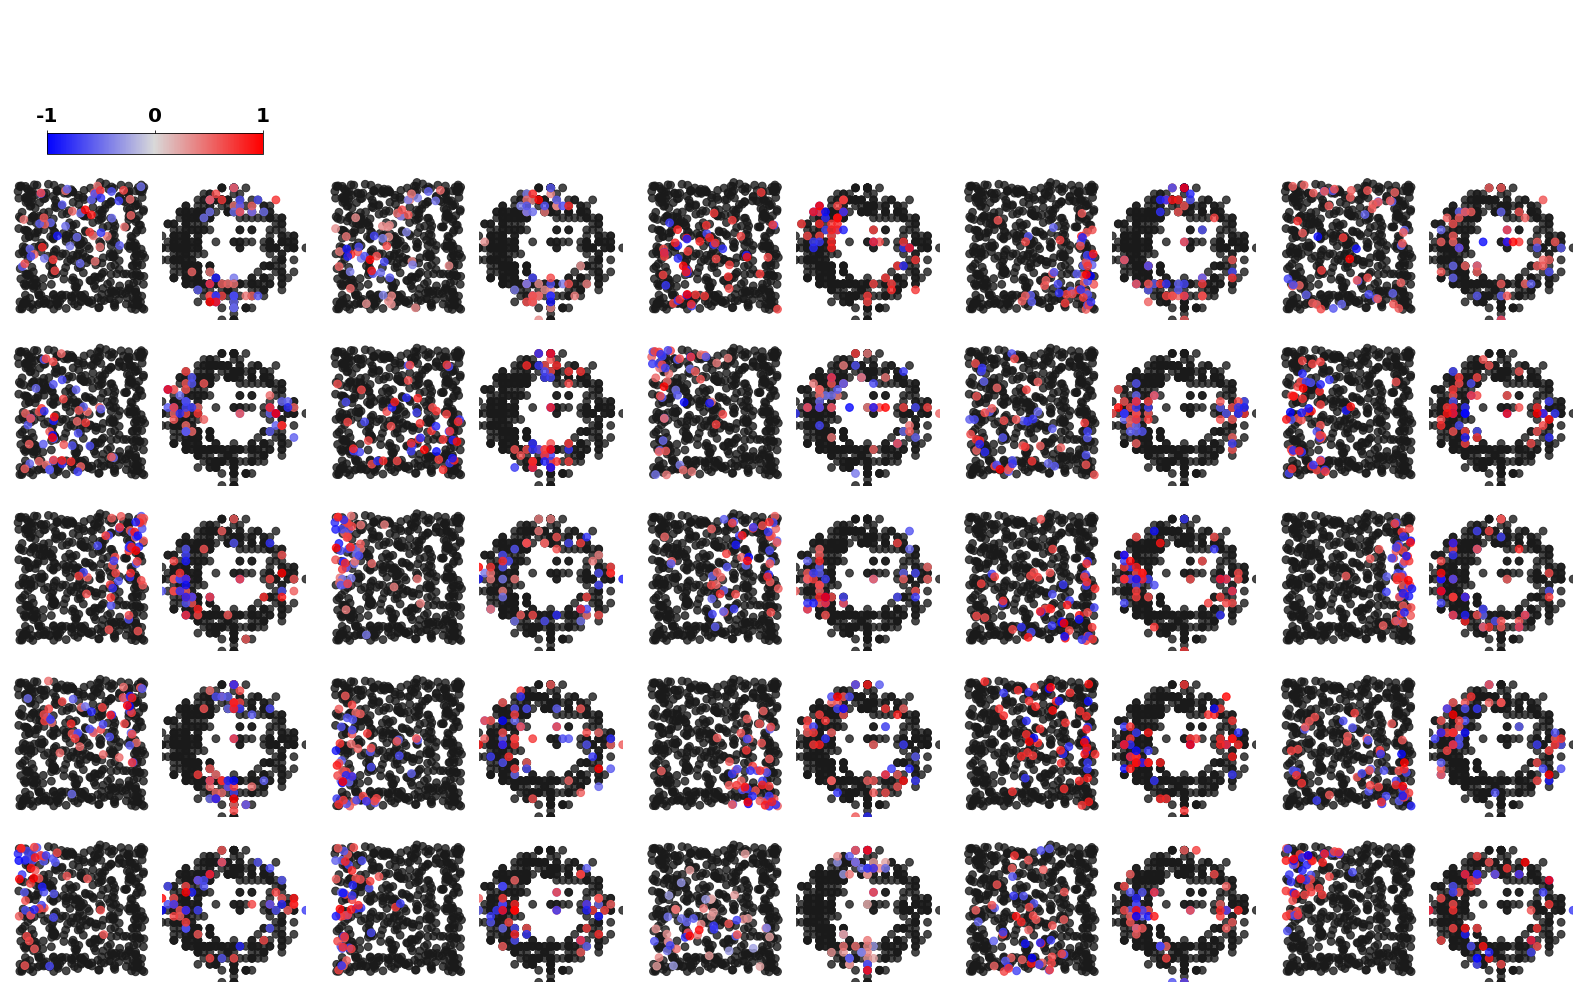

In [7]:
num_pooling_filters = 25
num_connected_weights = 50
filter_indices = None
fig_size = (10, 10)
spot_size = 60
fig = pf.plot_pooling_centers(analyzer.bf_stats, analyzer.cov["pooling_filters"], num_pooling_filters,
  num_connected_weights, filter_indices, spot_size, figsize=fig_size)
fig.savefig(analyzer.analysis_out_dir+"fig_reduc_pooling_centers.png", bbox_inches="tight")